# Train a FastText model on the SLED categorization dataset

In [ ]:
# Install and import fastText
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip

%cd fastText-0.9.2

!pip install .
import fasttext as ft

--2022-08-30 08:17:08--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2 [following]
--2022-08-30 08:17:08--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4369852 (4.2M) [application/zip]
Saving to: ‘v0.9.2.zip.1’

v0.9.2.zip.1        100%[===================>]   4.17M  --.-KB/s    in 0.1s    

2022-08-30 08:17:08 (35.2 MB/s) - ‘v0.9.2.zip.1’ saved [4369852/4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
replace fastText-0.9.2/.circleci/cmake_test.sh? [y]es, [

In [ ]:
# Install the parse module
!pip install parse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=ec0d0fa796d3b85582838527318547356f0672a68f2d284235ce54edd5b8d034
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built parse


In [ ]:
# Import necessary libraries (if there is an error "fasttext" not found, go to Runtime > Restart runtime, and try to run this cell again.)
import parse
import fasttext as ft
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import time

In [ ]:
# Upload the data to google collab and define paths to them
# (click on the Folder on the right of the window, and click on the file icon ("Upload to session storage")
train = "/content/sled_categorization_TRAINSMALL_PREPROCESSED.txt"

test = "/content/sled_categorization_TEST_PREPROCESSED.txt"

dev = "/content/sled_categorization_DEV_PREPROCESSED.txt"

In [ ]:
# Parse the file to separate labels from text
def parse_file(path: str):
    """Reads fasttext formatted file and returns labels, texts."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            print("error parsing line ", line)
    return labels, texts

In [ ]:
# Create a list of texts and labels from the train file
train_labels, train_texts = parse_file(train)

# Inspect the results
train_texts[:3]

['na tolminskem se je dopoldne zgodila prometna nesreča v kateri je umrl 43-letni voznik osebnega avtomobila po tem ko je zapeljal v 100 metrov globoko grapo  nesreča se je zgodila ob 916 uri po prvih ugotovitvah policistov je domačin peljal iz tolmina proti vasi zadlaz - žabče kjer je v neposredni bližini ene od tamkajšnjih stanovanjskih hiš zapeljal levo z vozišča globoko približno 100 metrov v grapo  poleg policistov iz tolmina in nove gorice ter novogoriške gorske policijske enote so na kraju nesreče posredovali tudi gasilci pripadniki gorske reševalne službe in reševalci iz tolmina v nadaljevanju je bila ugotovljena in potrjena identiteta voznika in sicer je za posledicami telesnih poškodb v prometni nesreči podlegel 43-letni voznik so sporočili iz policijske uprave nova gorica zdravnica je odredila sanitarno obdukcijo ki jo bodo opravili na inštitutu za sodno medicino v ljubljani o nesreči so obvestili tudi preiskovalno sodnico in državno tožilstvo v novi gorici',
 'na cesti zadl

In [ ]:
# Create a list of labels - by creating a set, we get only unique labels from the list of all labels,
# then we transform the set back to a list

LABELS = list(set(train_labels))

LABELS

['__label__druzba',
 '__label__prosticas',
 '__label__crnakronika',
 '__label__zabava',
 '__label__gospodarstvo',
 '__label__izobrazevanje',
 '__label__okolje',
 '__label__sport',
 '__label__vreme',
 '__label__zdravje',
 '__label__znanost',
 '__label__kultura',
 '__label__politika']

## Hyperparameters search

In [ ]:
def prediction_to_label(prediction):
    """Transforms predictions as returned by fasttext into pure labels."""
    return np.array(prediction[0])[:, 0]

# Create a function to evaluate the results (it calculates the scores and creates a confusion matrix)
def plot_cm():
    """
    Plots confusion matrix for prediction on the test set.
    Takes the predictions, named as y_pred, true values, named as y_true,
    and labels, named as LABELS.
    """
    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()

    # Calculate micro and macro F1 scores
    microF1 = f1_score(y_true, y_pred, labels=LABELS, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=LABELS, average ="macro")

    print(f"Micro F1: {microF1:0.4}, Macro F1: {macroF1:0.4}")

    return microF1, macroF1

I'll experiment with various epochs to see which epoch number provides the best results

In [ ]:
# Create a list with results
results = []

Training started for epoch_num 700.
Training finished. Testing started.
Training took 12.81 minutes.


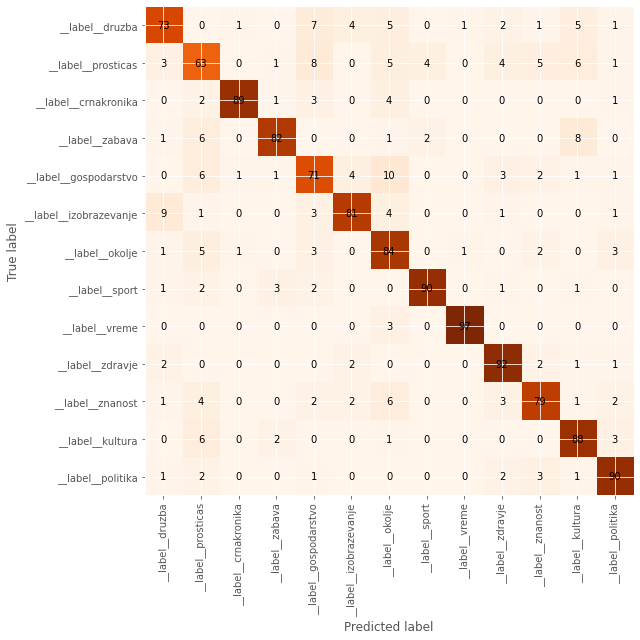

Micro F1: 0.83, Macro F1: 0.8306
Testing took 0.02 minutes.


Training started for epoch_num 800.
Training finished. Testing started.
Training took 13.89 minutes.


<Figure size 432x288 with 0 Axes>

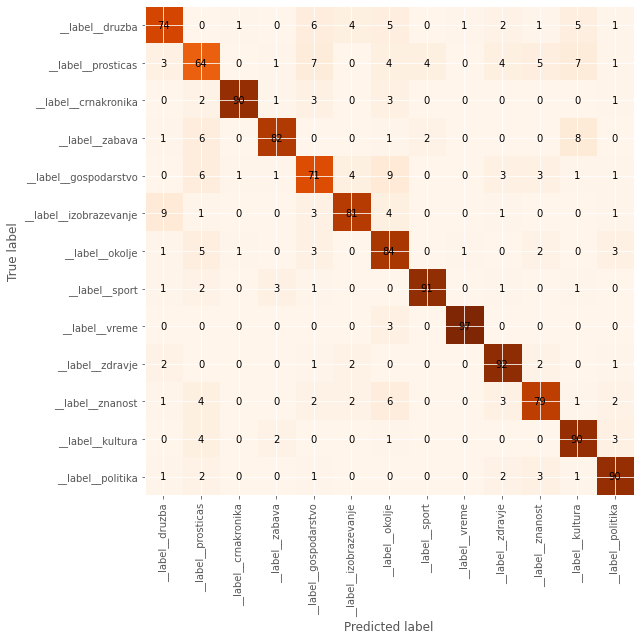

Micro F1: 0.8346, Macro F1: 0.8348
Testing took 0.02 minutes.


Training started for epoch_num 900.
Training finished. Testing started.
Training took 14.86 minutes.


<Figure size 432x288 with 0 Axes>

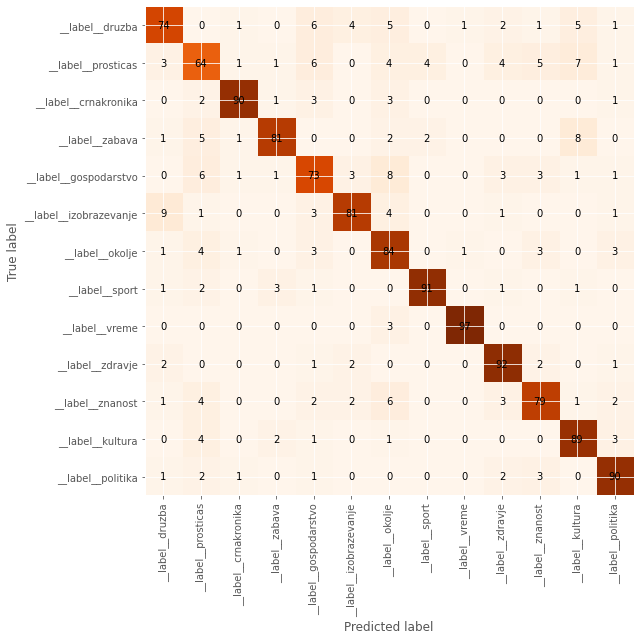

Micro F1: 0.8346, Macro F1: 0.8347
Testing took 0.02 minutes.


Training started for epoch_num 1000.
Training finished. Testing started.
Training took 15.43 minutes.


<Figure size 432x288 with 0 Axes>

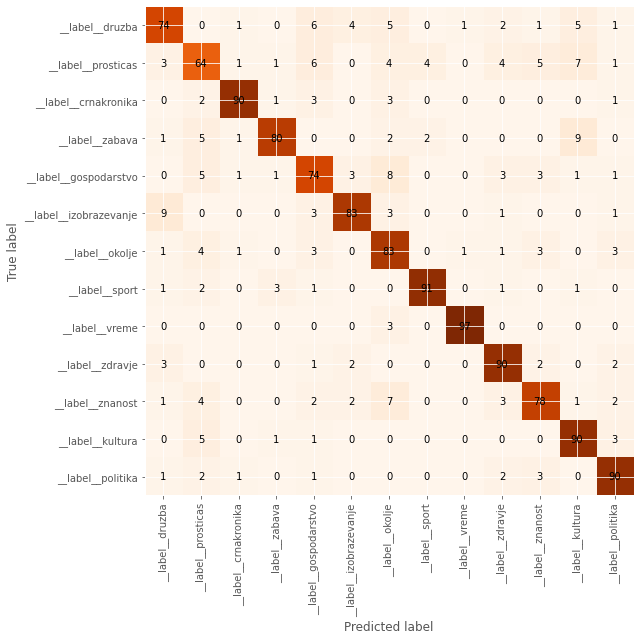

Micro F1: 0.8338, Macro F1: 0.8339
Testing took 0.02 minutes.




<Figure size 432x288 with 0 Axes>

In [ ]:
# Define which epochs we want to try
#exp_range = [10, 50, 100, 150]
# Additional experiments - the highest scores were achieved on 150 epochs
#exp_range = [200, 250, 300, 350, 400, 450, 500, 550, 600]
exp_range = [700, 800, 900, 1000]

for i in exp_range:
    print(f"Training started for epoch_num {i}.")

    training_start_time = time.time()

    model = ft.train_supervised(input=train,
                                epoch = i,
                                #lr = 0.7,
                                #wordNgrams=1,
                                verbose = 2
                                            )

    print(f"Training finished. Testing started.")
    print(f"Training took {round((time.time() - training_start_time)/60,2)} minutes.")

    testing_start_time = time.time()
    # Parse the dev files so that labels and texts are separated
    y_true, y_texts = parse_file(dev)

    # Evaluate the model on dev data
    y_pred = model.predict(y_texts)
    y_pred = prediction_to_label(y_pred)

    # Plot the confusion matrix:
    m, M = plot_cm()
    
    rezdict = dict(
        microF1=m,
        macroF1=M,
        epoch_num = i,
    )
    results.append(rezdict)

    print(f"Testing took {round((time.time() - testing_start_time)/60,2)} minutes.\n\n")

In [ ]:
# Test the model
model.predict("V Celju se je zgodila nesreča, umrla je 42-letna ženska.")

(('__label__zabava',), array([1.00000954]))

In [ ]:
results

[{'microF1': 0.15846153846153846,
  'macroF1': 0.10194771788090756,
  'epoch_num': 10},
 {'microF1': 0.41846153846153844,
  'macroF1': 0.4054240167951187,
  'epoch_num': 50},
 {'microF1': 0.6223076923076923,
  'macroF1': 0.6211575882523663,
  'epoch_num': 100},
 {'microF1': 0.7123076923076922,
  'macroF1': 0.7066407993101933,
  'epoch_num': 150},
 {'microF1': 0.7492307692307694,
  'macroF1': 0.7471417299434271,
  'epoch_num': 200},
 {'microF1': 0.7676923076923077,
  'macroF1': 0.7686271631185997,
  'epoch_num': 250},
 {'microF1': 0.7907692307692308,
  'macroF1': 0.7932182933066403,
  'epoch_num': 300},
 {'microF1': 0.8000000000000002,
  'macroF1': 0.801711647118303,
  'epoch_num': 350},
 {'microF1': 0.8053846153846154,
  'macroF1': 0.8070391572223017,
  'epoch_num': 400},
 {'microF1': 0.8084615384615385,
  'macroF1': 0.810002604002464,
  'epoch_num': 450},
 {'microF1': 0.8161538461538461,
  'macroF1': 0.8174033688519522,
  'epoch_num': 500},
 {'microF1': 0.82, 'macroF1': 0.821055107038

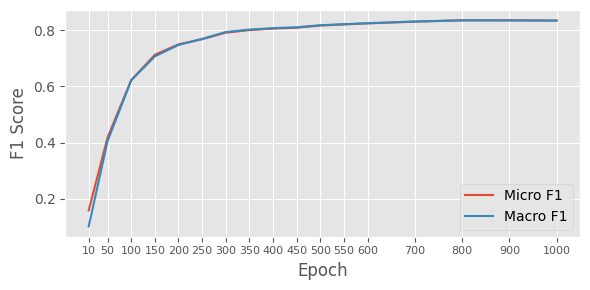

In [ ]:
# Analyse the results of experiments
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use("ggplot")

# make data

x = []
mi = []
ma = []

for i in results:
    x.append(i['epoch_num'])
    mi.append(i['microF1'])
    ma.append(i["macroF1"])

# plot
plt.figure(figsize=(6,3), dpi=100)

plt.plot(x, mi, label="Micro F1")
plt.plot(x, ma, label="Macro F1")

plt.xticks(x, fontsize = 8)

plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc="lower right")

plt.tight_layout()

#plt.savefig(Epoch-number-hyperparameter-search.png")
plt.show()


As we can see from the figure, the micro and macro F1 scores keep rising until the epoch 800, afterwards, the scores remain around 0.83. For testing, I will use 800 epochs.

In [ ]:
# Save results of the hyperparameter search as a JSON file
import json

with open("SLED-hyperparameter-search-results.json","w") as file:
  json.dump(results, file)

## Training the model and testing on the test set

Training started, run 0.
Training finished. Testing started.
Training took 11.36 minutes.


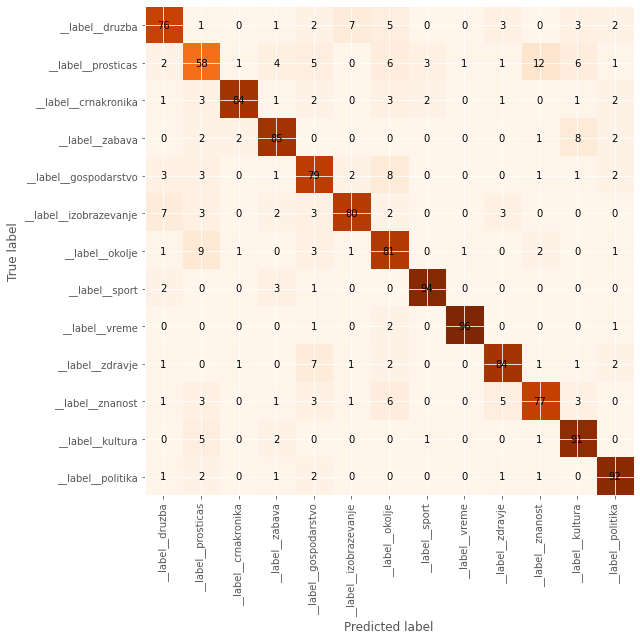

Micro F1: 0.8285, Macro F1: 0.8282
Testing took 0.02 minutes.


Training started, run 1.
Training finished. Testing started.
Training took 11.94 minutes.


<Figure size 432x288 with 0 Axes>

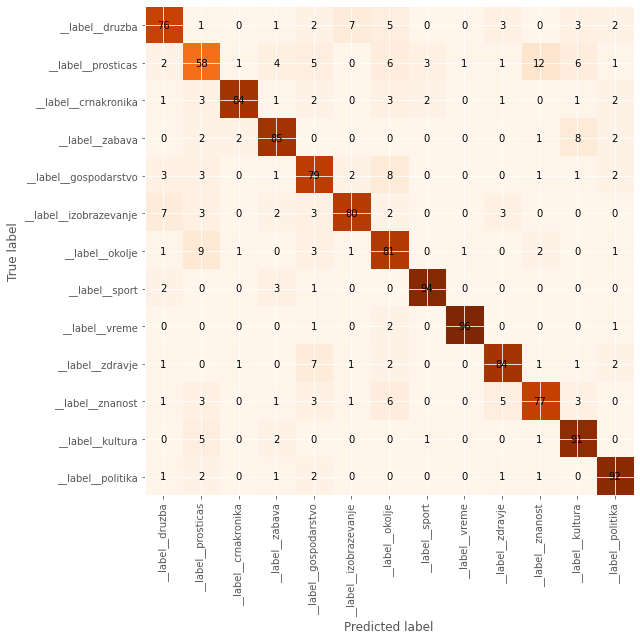

Micro F1: 0.8285, Macro F1: 0.8282
Testing took 0.02 minutes.


Training started, run 2.
Training finished. Testing started.
Training took 10.93 minutes.


<Figure size 432x288 with 0 Axes>

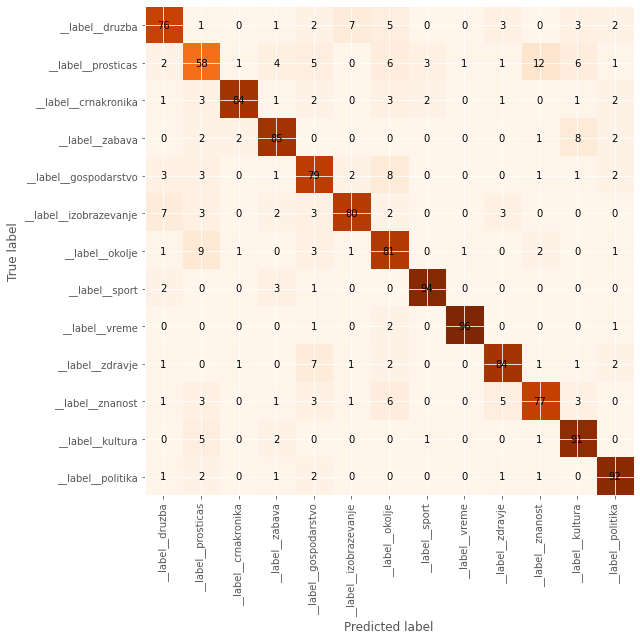

Micro F1: 0.8285, Macro F1: 0.8282
Testing took 0.02 minutes.




<Figure size 432x288 with 0 Axes>

In [ ]:
# Train the model 3 times to see if the results change much.

test_results = []

for i in range(3):
    print(f"Training started, run {i}.")

    training_start_time = time.time()

    model = ft.train_supervised(input=train,
                                epoch = 800,
                                verbose = 2)

    print(f"Training finished. Testing started.")
    print(f"Training took {round((time.time() - training_start_time)/60,2)} minutes.")

    testing_start_time = time.time()
    
    # Parse the test files so that labels and texts are separated
    y_true, y_texts = parse_file(test)

    # Test the model on test data
    y_pred = model.predict(y_texts)
    y_pred = prediction_to_label(y_pred)

    # Plot the confusion matrix:
    m, M = plot_cm()
    
    rezdict = dict(
        microF1=m,
        macroF1=M,
        epoch_num = i,
        y_true = {"y_true": y_true, "y_texts": y_texts},
        y_pred = y_pred,
    )
    test_results.append(rezdict)

    print(f"Testing took {round((time.time() - testing_start_time)/60,2)} minutes.\n\n")

In [ ]:
# Inspect results in a dataframe format

df = pd.DataFrame(test_results)

df

,microF1,macroF1,epoch_num,y_true,y_pred
0,0.828462,0.828174,0,"{'y_true': ['__label__crnakronika', '__label__...","[__label__crnakronika, __label__crnakronika, _..."
1,0.828462,0.828174,1,"{'y_true': ['__label__crnakronika', '__label__...","[__label__crnakronika, __label__crnakronika, _..."
2,0.828462,0.828174,2,"{'y_true': ['__label__crnakronika', '__label__...","[__label__crnakronika, __label__crnakronika, _..."


As we can see, the results in different runs remain stable - the model achieves micro F1 0.8285 and macro F1 0.8282.

In [ ]:
# Save results as csv file
df.to_csv("SLED-results-on-test.csv", sep = "\t")